# Vector Space Semantics for Similarity between EastEnders Characters

You will be creating a vector representation of a document containing lines spoken by a character in the EastEnders script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximally distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those character document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, you can only use a maximum of the first **300 lines** of each character in the training data `training.csv` to create the training documents and a maximum of the first **50 lines** in the validation and test data (from `val.csv` and `test.csv`). This makes it more challenging, as the number of lines spoken by a character can't be used directly or otherwise as a feature.





In [ ]:
!pip install nltk

In [ ]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('averaged_perceptron_tagger')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from collections import defaultdict


import seaborn as sns
import matplotlib.pyplot as plt

import math

import nltk

from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
pd.options.display.max_colwidth=500

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
val_path ='val.csv'
val_data = pd.read_csv(val_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
14008,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
14009,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
14010,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
14011,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


Question 3 - adding dialogue context and scene features


In [ ]:
def create_character_document_from_dataframe(df, max_line_count, context_window=3):
    """
    Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them. Includes context lines from the same scene.

    ::max_line_count:: the maximum number of lines to be added per character
    ::context_window:: number of lines before and after to include as context
    """
    character_docs = {}
    character_line_count = {}

    # Grouping by episode and scene
    grouped = df.groupby(['Episode', 'Scene'])

    for (episode, scene), scene_data in grouped:
        lines = scene_data['Line'].fillna("").astype(str).values  # Convert NaNs to empty strings and ensure all are strings
        characters = scene_data['Character_name'].values

        for idx, (line, name) in enumerate(zip(lines, characters)):
            # This is to skip any empty lines
            if not line.strip():
                continue

            # Initializing the character document
            if name not in character_docs:
                character_docs[name] = ""
                character_line_count[name] = 0

            # If max count is acheived it stops adding lines
            if character_line_count[name] >= max_line_count:
                continue

            # Adding target line
            context_lines = [line]

            # adding context from lines before and after in the scene
            start_idx = max(0, idx - context_window)
            end_idx = min(len(lines), idx + context_window + 1)
            for context_idx in range(start_idx, end_idx):
                if context_idx != idx:  # Avoiding duplication of the target line
                    context_line = lines[context_idx].strip()
                    if context_line:  # if empty line then skip
                        context_lines.append(context_line)

            # Concatenating the lines
            character_docs[name] += " ".join(context_lines) + " _EOL_ "
            character_line_count[name] += 1

    print("Lines per character:", character_line_count)
    return character_docs


In [ ]:
# number of words each character has in the training set
# only the first 300 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300, context_window=2)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

Lines per character: {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'ROXY': 300, 'TANYA': 300, 'SEAN': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}
Num. Characters:  16 

SHIRLEY Number of Words:  13107
OTHER Number of Words:  10277
JACK Number of Words:  13318
RONNIE Number of Words:  13381
ROXY Number of Words:  13095
TANYA Number of Words:  12970
SEAN Number of Words:  11639
MAX Number of Words:  14506
IAN Number of Words:  13273
JANE Number of Words:  13023
STACEY Number of Words:  12883
PHIL Number of Words:  14569
HEATHER Number of Words:  13372
MINTY Number of Words:  14048
CHRISTIAN Number of Words:  13582
CLARE Number of Words:  14207
total words 211250


Question 1 to improve pre process

In [ ]:
def pre_process(character_text, stopwords_flag=True, lemmatization_flag=True):

    # Lowercasing
    character_text = character_text.lower()

    # Removing punctuation
    character_text = re.sub(r'[^\w\s]', '', character_text)

    # Tokenization
    tokens = word_tokenize(character_text)

    # Stopword removal
    if stopwords_flag:
        stop_words = set(stopwords.words('english'))
        custom_vocab = ['not', 'no']  # Custom vocabulary to retain negations
        tokens = [word for word in tokens if word not in stop_words or word in custom_vocab]

    # Lemmatization
    if lemmatization_flag:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens


In [ ]:
# creating a list of pairs of character name and pre processed character
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

Question 2 - Improving feature extraction

In [ ]:
# creating a function here for extracting n grams and POS tags
def ngrams_and_pos(tokens):
    bigrams = ['_'.join(grams) for grams in zip(tokens[:-1], tokens[1:])]  # bigrams
    trigrams = ['_'.join(grams) for grams in zip(tokens[:-2], tokens[1:-1], tokens[2:])]  # trigrams
    pos_tags = nltk.pos_tag(tokens)
    pos_features = [f'POS_{pos}' for word, pos in pos_tags]
    return bigrams + trigrams + pos_features

def to_feature_vector_dictionary(character_doc, extra_features):

    # Token counts
    counts = Counter(character_doc)

    # Adding ngrams and POS tags as additional features
    ngram_pos_features = ngrams_and_pos(character_doc)
    for feature in ngram_pos_features:
        counts[feature] += 1

    for feature in extra_features:
        counts[feature] += 1

    return dict(counts)


In [ ]:
# Global variables to store fitted instances
corpusVectorizer = DictVectorizer()
tfidf_transformer = TfidfTransformer()
feature_selector = None

def create_document_matrix_from_corpus(corpus, fitting=False, k_best=5000):
    """
    Transforms the corpus into a feature matrix with ngrams, POS tags, and TF-IDF.
    Uses K-best feature selection for reduction.

    """
    global feature_selector

    # Converts the corpus to a list of dictionaries
    feature_dicts = [to_feature_vector_dictionary(doc, []) for name, doc in corpus]

    if fitting:
        # Fiting the vectorizer and transformer
        corpusVectorizer.fit(feature_dicts)
        tfidf_transformer.fit(corpusVectorizer.transform(feature_dicts))
        doc_feature_matrix = tfidf_transformer.transform(corpusVectorizer.transform(feature_dicts))

        # K-best feature selection
        feature_selector = SelectKBest(chi2, k=k_best)  # Create feature selector
        feature_selector.fit(doc_feature_matrix, [name for name, doc in corpus])  # Fit on training
        doc_feature_matrix = feature_selector.transform(doc_feature_matrix)  # Transform training data
    else:
        # Transforming using already fitted vectorizer and transformer
        if not corpusVectorizer:
            raise ValueError("DictVectorizer must be fitted during training before using validation.")
        doc_feature_matrix = tfidf_transformer.transform(corpusVectorizer.transform(feature_dicts))

        if feature_selector is not None:
            doc_feature_matrix = feature_selector.transform(doc_feature_matrix)

    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, k_best=5000)



In [ ]:
training_feature_matrix

<16x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 6596 stored elements in Compressed Sparse Row format>

In [ ]:
# the validation data where only 50 lines are used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=50)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# creating list of pairs of character name and pre-processed character
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

Lines per character: {'OTHER': 50, 'HEATHER': 43, 'TANYA': 50, 'JACK': 50, 'RONNIE': 40, 'JANE': 50, 'STACEY': 50, 'SEAN': 50, 'PHIL': 32, 'SHIRLEY': 50, 'ROXY': 30, 'IAN': 50, 'MINTY': 50, 'CHRISTIAN': 30, 'CLARE': 28, 'MAX': 50}
Num. Characters:  16 

OTHER Num of Words:  2633
HEATHER Num of Words:  2416
TANYA Num of Words:  2813
JACK Num of Words:  3062
RONNIE Num of Words:  2206
JANE Num of Words:  3382
STACEY Num of Words:  2954
SEAN Num of Words:  3101
PHIL Num of Words:  1962
SHIRLEY Num of Words:  3223
ROXY Num of Words:  1511
IAN Num of Words:  3361
MINTY Num of Words:  3197
CHRISTIAN Num of Words:  1823
CLARE Num of Words:  1968
MAX Num of Words:  2926
total words 42538


In [ ]:
# Transforming the val_feature_matrix
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [ ]:
val_feature_matrix

<16x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 659 stored elements in Compressed Sparse Row format>

In [ ]:
def compute_cosine_similarity(v1, v2):

    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))

    return manual_cosine_similarity

In [ ]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents

    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )

    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

Pre processing grid search Q1

Question 4 - Grid Search

In [ ]:
from sklearn.model_selection import ParameterGrid

# pre-processing parameter grid
preprocess_params = {
    'stopwords': [True, False],
    'lemmatization': [True, False],
    'ngrams': [(1, 1), (1, 2), (1, 3)],  # unigrams, bigrams, trigrams
    'context_window': [1, 2, 3],  # number of surrounding lines
}

preprocess_combinations = list(ParameterGrid(preprocess_params))

# grid search for Q1
best_preprocess_params = None
best_mean_rank_q1 = float('inf')

for params in preprocess_combinations:
    # Extracting the parameter values
    stopwords_flag = params['stopwords']
    lemmatization_flag = params['lemmatization']
    ngrams = params['ngrams']
    context_window = params['context_window']

    # Pre processing training and validation data
    train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300, context_window=context_window)
    val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=50, context_window=context_window)
    training_corpus = [(name, pre_process(doc, stopwords_flag=stopwords_flag, lemmatization_flag=lemmatization_flag)) for name, doc in sorted(train_character_docs.items())]
    val_corpus = [(name, pre_process(doc, stopwords_flag=stopwords_flag, lemmatization_flag=lemmatization_flag)) for name, doc in sorted(val_character_docs.items())]

    training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)
    val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)


    mean_rank, _, acc, _ = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

    # Tracking the best parameters
    if mean_rank < best_mean_rank_q1:
        best_mean_rank_q1 = mean_rank
        best_preprocess_params = params

print(f"Best Pre-processing Params: {best_preprocess_params}, Mean Rank: {best_mean_rank_q1}")


Lines per character: {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'ROXY': 300, 'TANYA': 300, 'SEAN': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}
Lines per character: {'OTHER': 50, 'HEATHER': 43, 'TANYA': 50, 'JACK': 50, 'RONNIE': 40, 'JANE': 50, 'STACEY': 50, 'SEAN': 50, 'PHIL': 32, 'SHIRLEY': 50, 'ROXY': 30, 'IAN': 50, 'MINTY': 50, 'CHRISTIAN': 30, 'CLARE': 28, 'MAX': 50}
mean rank 2.0
mean cosine similarity 0.3746652189058659
12 correct out of 16 / accuracy: 0.75
Lines per character: {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'ROXY': 300, 'TANYA': 300, 'SEAN': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}
Lines per character: {'OTHER': 50, 'HEATHER': 43, 'TANYA': 50, 'JACK': 50, 'RONNIE': 40, 'JANE': 50, 'STACEY': 50, 'SEAN': 50, 'PHIL': 32, 'SHIRLEY': 50, 'ROXY': 30, 'IAN': 50, 'MIN

Feature extraction grid search Q2

In [ ]:
feature_params = {
    'tfidf': [True, False],
    'pos_tags': [True, False],
    'k_best': [1000, 3000, 5000],
}

feature_combinations = list(ParameterGrid(feature_params))

best_feature_params = None
best_mean_rank_q2 = float('inf')

for params in feature_combinations:
    tfidf = params['tfidf']
    pos_tags = params['pos_tags']
    k_best = params['k_best']

    # Applying the best pre-processing settings
    context_window = best_preprocess_params['context_window']
    stopwords_flag = best_preprocess_params['stopwords']
    lemmatization_flag = best_preprocess_params['lemmatization']

    train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300, context_window=context_window)
    val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=50, context_window=context_window)
    training_corpus = [(name, pre_process(doc, stopwords_flag=stopwords_flag, lemmatization_flag=lemmatization_flag)) for name, doc in sorted(train_character_docs.items())]
    val_corpus = [(name, pre_process(doc, stopwords_flag=stopwords_flag, lemmatization_flag=lemmatization_flag)) for name, doc in sorted(val_character_docs.items())]

    # feature matrices with selected k-best features
    training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, k_best=k_best)
    val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

    mean_rank, _, acc, _ = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

    # Tracking the best parameters
    if mean_rank < best_mean_rank_q2:
        best_mean_rank_q2 = mean_rank
        best_feature_params = params

print(f"Best Feature Extraction Params: {best_feature_params}, Mean Rank: {best_mean_rank_q2}")


Lines per character: {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'ROXY': 300, 'TANYA': 300, 'SEAN': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}
Lines per character: {'OTHER': 50, 'HEATHER': 43, 'TANYA': 50, 'JACK': 50, 'RONNIE': 40, 'JANE': 50, 'STACEY': 50, 'SEAN': 50, 'PHIL': 32, 'SHIRLEY': 50, 'ROXY': 30, 'IAN': 50, 'MINTY': 50, 'CHRISTIAN': 30, 'CLARE': 28, 'MAX': 50}
mean rank 1.875
mean cosine similarity 0.5307102214271326
11 correct out of 16 / accuracy: 0.6875
Lines per character: {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'ROXY': 300, 'TANYA': 300, 'SEAN': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}
Lines per character: {'OTHER': 50, 'HEATHER': 43, 'TANYA': 50, 'JACK': 50, 'RONNIE': 40, 'JANE': 50, 'STACEY': 50, 'SEAN': 50, 'PHIL': 32, 'SHIRLEY': 50, 'ROXY': 30, 'IAN': 50, 

Context line grid search

In [ ]:
context_params = {
    'context_window': [1, 2, 3],
    'max_line_count': [200, 300, 400],
}

context_combinations = list(ParameterGrid(context_params))

best_context_params = None
best_mean_rank_q3 = float('inf')

for params in context_combinations:
    context_window = params['context_window']
    max_line_count = params['max_line_count']

    # Applying the best pre-processing and feature extraction settings
    stopwords_flag = best_preprocess_params['stopwords']
    lemmatization_flag = best_preprocess_params['lemmatization']
    k_best = best_feature_params['k_best']

    train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=max_line_count, context_window=context_window)
    val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=50, context_window=context_window)
    training_corpus = [(name, pre_process(doc, stopwords_flag=stopwords_flag, lemmatization_flag=lemmatization_flag)) for name, doc in sorted(train_character_docs.items())]
    val_corpus = [(name, pre_process(doc, stopwords_flag=stopwords_flag, lemmatization_flag=lemmatization_flag)) for name, doc in sorted(val_character_docs.items())]

    training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, k_best=k_best)
    val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

    mean_rank, _, acc, _ = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

    # Tracking the best parameters
    if mean_rank < best_mean_rank_q3:
        best_mean_rank_q3 = mean_rank
        best_context_params = params

print(f"Best Context Params: {best_context_params}, Mean Rank: {best_mean_rank_q3}")


Lines per character: {'SHIRLEY': 200, 'OTHER': 200, 'JACK': 200, 'RONNIE': 200, 'ROXY': 200, 'TANYA': 200, 'SEAN': 200, 'MAX': 200, 'IAN': 200, 'JANE': 200, 'STACEY': 200, 'PHIL': 200, 'HEATHER': 200, 'MINTY': 200, 'CHRISTIAN': 200, 'CLARE': 200}
Lines per character: {'OTHER': 50, 'HEATHER': 43, 'TANYA': 50, 'JACK': 50, 'RONNIE': 40, 'JANE': 50, 'STACEY': 50, 'SEAN': 50, 'PHIL': 32, 'SHIRLEY': 50, 'ROXY': 30, 'IAN': 50, 'MINTY': 50, 'CHRISTIAN': 30, 'CLARE': 28, 'MAX': 50}
mean rank 2.375
mean cosine similarity 0.4859015565600002
8 correct out of 16 / accuracy: 0.5
Lines per character: {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'ROXY': 300, 'TANYA': 300, 'SEAN': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}
Lines per character: {'OTHER': 50, 'HEATHER': 43, 'TANYA': 50, 'JACK': 50, 'RONNIE': 40, 'JANE': 50, 'STACEY': 50, 'SEAN': 50, 'PHIL': 32, 'SHIRLEY': 50, 'ROXY': 30, 'IAN': 50, 'MIN

In [ ]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [ ]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 2.25
mean cosine similarity 0.5574991694375524
10 correct out of 16 / accuracy: 0.625


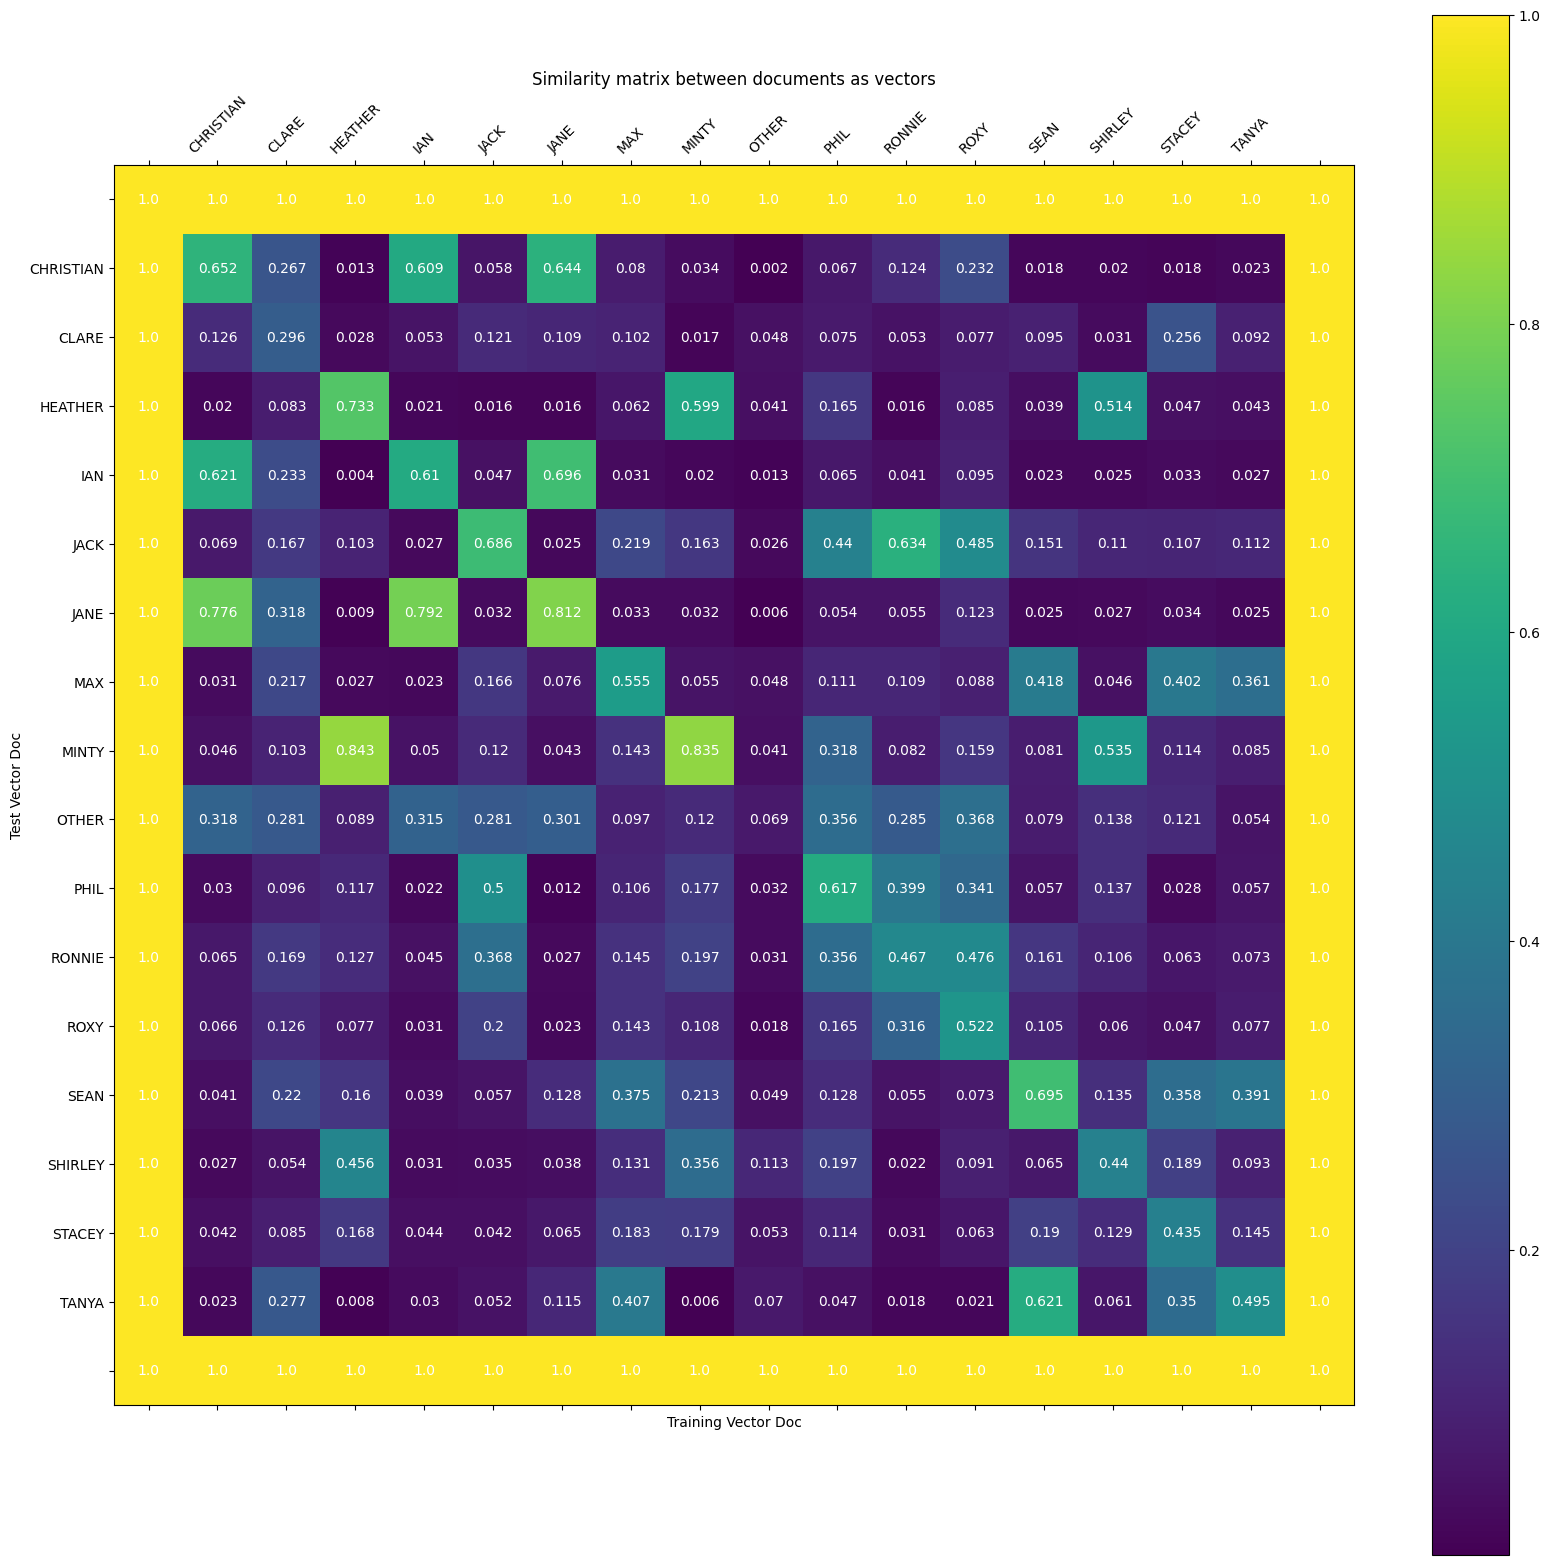

In [ ]:
plot_heat_map_similarity(df)

Question 5 - closest and furthest

In [ ]:
def find_closest_and_furthest(df):
    """Identify the closest and furthest non-self characters for each target."""
    closest_non_self_matches = {}
    furthest_matches = {}

    for target in df['doc1'].unique():
        target_df = df[df['doc1'] == target].sort_values(by='similarity', ascending=False)
        non_self_matches = target_df[target_df['doc2'] != target]

        # Closest non-self match
        closest_match = non_self_matches.iloc[0] if not non_self_matches.empty else None

        # Furthest match
        furthest_match = target_df.iloc[-1]

        closest_non_self_matches[target] = {
            "closest_character": closest_match['doc2'] if closest_match is not None else None,
            "similarity": closest_match['similarity'] if closest_match is not None else None
        }

        furthest_matches[target] = {
            "furthest_character": furthest_match['doc2'],
            "similarity": furthest_match['similarity']
        }

    return closest_non_self_matches, furthest_matches


closest_non_self_matches, furthest_matches = find_closest_and_furthest(df)

print("Closest non-self matches:")
for char, data in closest_non_self_matches.items():
    print(f"{char} -> Closest non-self: {data['closest_character']} (Similarity: {data['similarity']:.3f})")

print("\nFurthest matches:")
for char, data in furthest_matches.items():
    print(f"{char} -> Furthest: {data['furthest_character']} (Similarity: {data['similarity']:.3f})")


Closest non-self matches:
CHRISTIAN -> Closest non-self: JANE (Similarity: 0.644)
CLARE -> Closest non-self: STACEY (Similarity: 0.256)
HEATHER -> Closest non-self: MINTY (Similarity: 0.599)
IAN -> Closest non-self: JANE (Similarity: 0.696)
JACK -> Closest non-self: RONNIE (Similarity: 0.634)
JANE -> Closest non-self: IAN (Similarity: 0.792)
MAX -> Closest non-self: SEAN (Similarity: 0.418)
MINTY -> Closest non-self: HEATHER (Similarity: 0.843)
OTHER -> Closest non-self: ROXY (Similarity: 0.368)
PHIL -> Closest non-self: JACK (Similarity: 0.500)
RONNIE -> Closest non-self: ROXY (Similarity: 0.476)
ROXY -> Closest non-self: RONNIE (Similarity: 0.316)
SEAN -> Closest non-self: TANYA (Similarity: 0.391)
SHIRLEY -> Closest non-self: HEATHER (Similarity: 0.456)
STACEY -> Closest non-self: SEAN (Similarity: 0.190)
TANYA -> Closest non-self: SEAN (Similarity: 0.621)

Furthest matches:
CHRISTIAN -> Furthest: OTHER (Similarity: 0.002)
CLARE -> Furthest: MINTY (Similarity: 0.017)
HEATHER -> Furt

 # Final test data


Lines per character: {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'ROXY': 300, 'TANYA': 300, 'SEAN': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}
Num. Characters:  16 

Total words: 134747
Lines per character: {'SHIRLEY': 50, 'OTHER': 50, 'HEATHER': 50, 'PHIL': 41, 'SEAN': 50, 'TANYA': 50, 'MAX': 50, 'JACK': 50, 'IAN': 50, 'JANE': 50, 'STACEY': 50, 'ROXY': 48, 'RONNIE': 50, 'CHRISTIAN': 50, 'MINTY': 48, 'CLARE': 45}
Num. Characters:  16 

Total words: 22182
mean rank 1.5625
mean cosine similarity 0.5409742090120306
10 correct out of 16 / accuracy: 0.625
Mean Rank (Test Data): 1.562
Mean Cosine Similarity (Test Data): 0.541
Accuracy (Test Data): 0.625


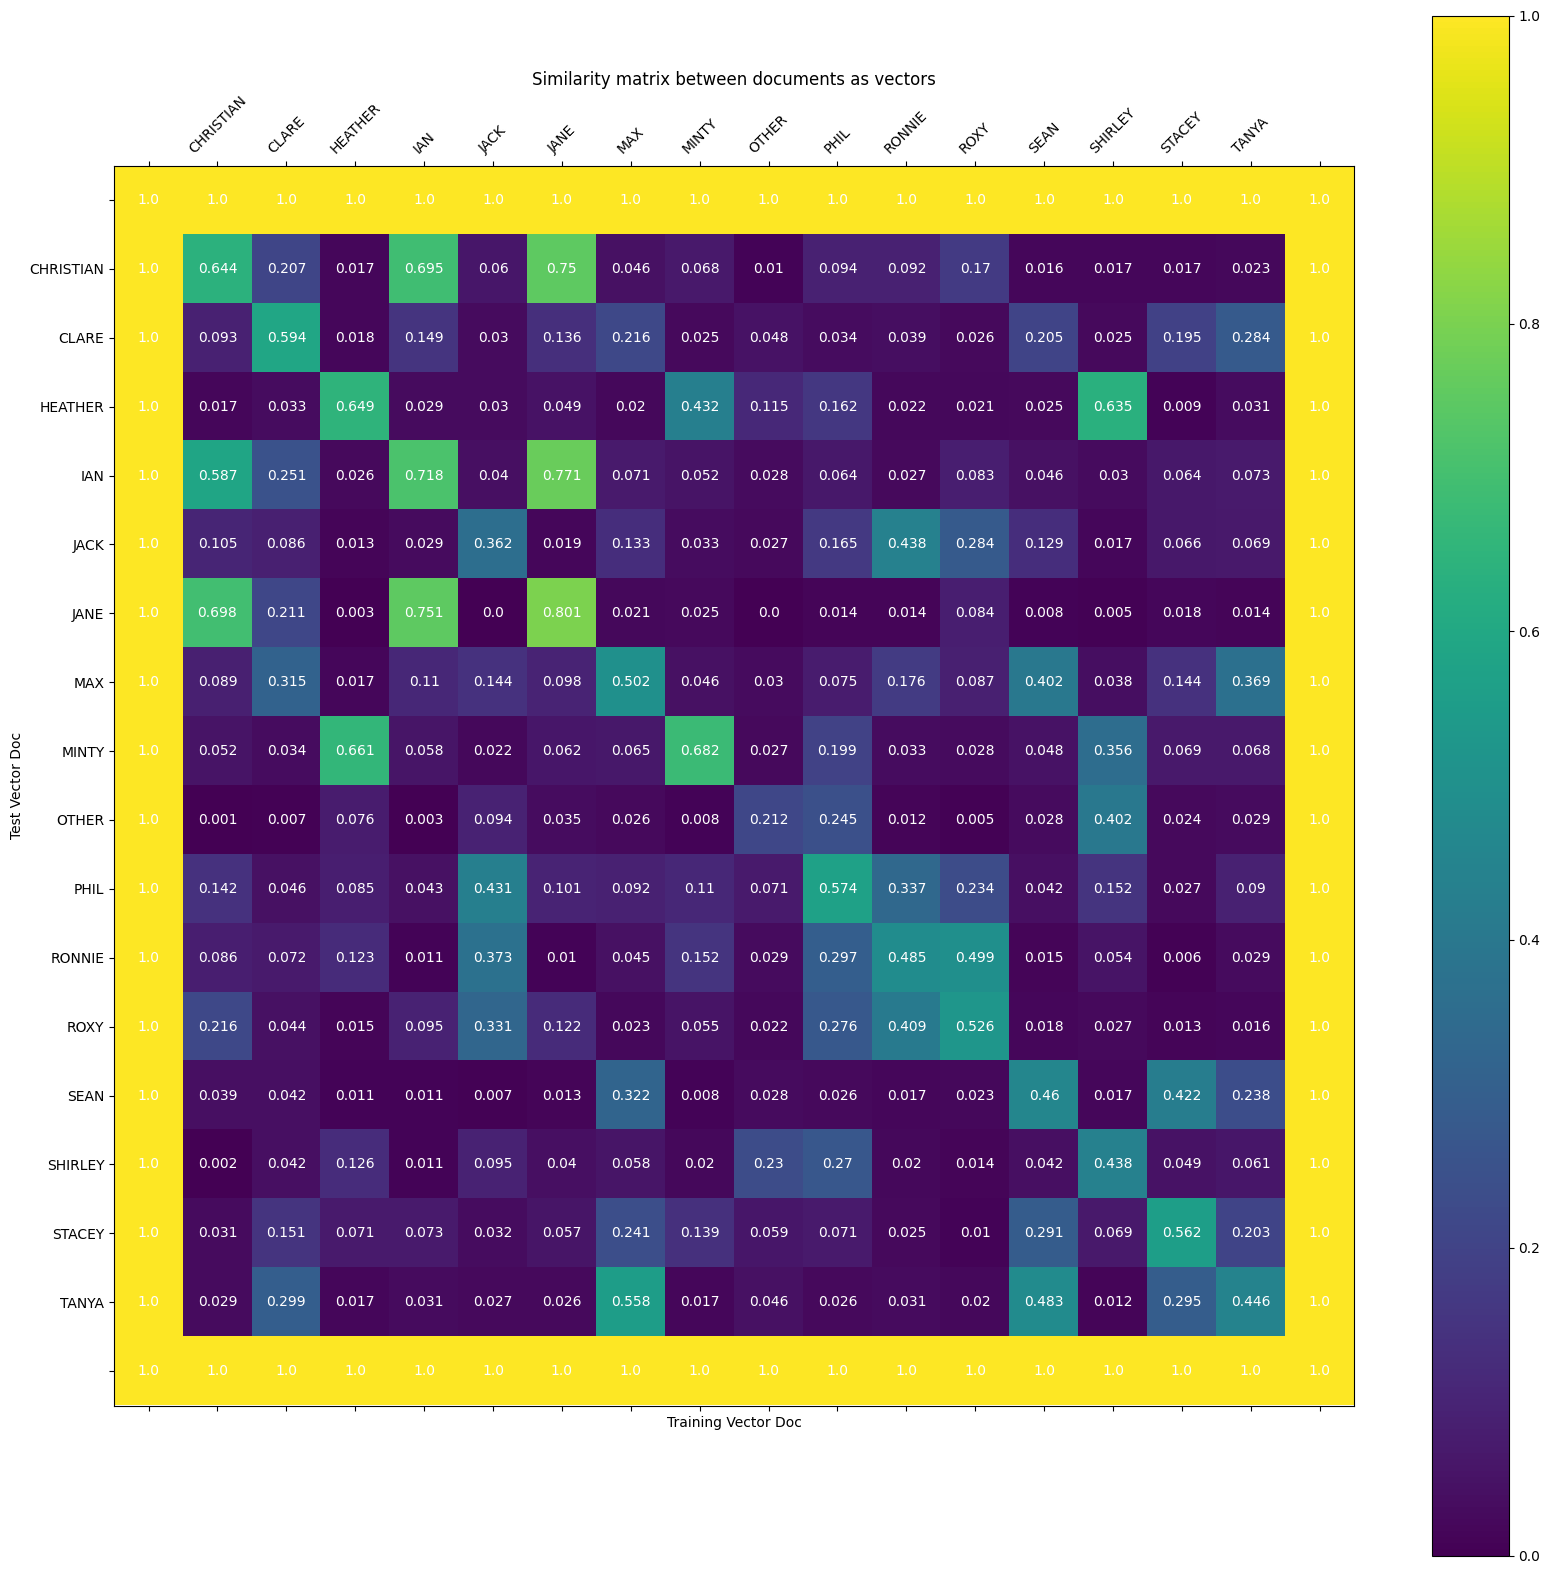

In [ ]:
# Ensure transformers are globally available and reset
corpusVectorizer = DictVectorizer()  # Sparse matrix creator
tfidf_transformer = TfidfTransformer()  # TF-IDF transformer
feature_selector = None  # K-best feature selector (initialized globally)

# Step 1: Training Data (First 300 Lines Per Character)
# Using the best context window size and max_line_count
best_context_window = best_context_params['context_window']
best_max_line_count = best_context_params['max_line_count']

train_character_docs = create_character_document_from_dataframe(
    train_data, max_line_count=best_max_line_count, context_window=best_context_window
)
print('Num. Characters: ', len(train_character_docs.keys()), "\n")
total_words = sum(len(doc.split()) for doc in train_character_docs.values())
print("Total words:", total_words)

# Create training corpus and labels using the best pre-processing settings
best_stopwords_flag = best_preprocess_params['stopwords']
best_lemmatization_flag = best_preprocess_params['lemmatization']
training_corpus = [(name, pre_process(doc, stopwords_flag=best_stopwords_flag, lemmatization_flag=best_lemmatization_flag))
                   for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

# Create training feature matrix using the best feature extraction settings
best_k_best = best_feature_params['k_best']
training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, k_best=best_k_best)

# Step 2: Test Data (First 50 Lines Per Character)
test_character_docs = create_character_document_from_dataframe(
    test_data, max_line_count=50, context_window=best_context_window
)
print('Num. Characters: ', len(test_character_docs.keys()), "\n")
total_words = sum(len(doc.split()) for doc in test_character_docs.values())
print("Total words:", total_words)

# Create test corpus and labels
test_corpus = [(name, pre_process(doc, stopwords_flag=best_stopwords_flag, lemmatization_flag=best_lemmatization_flag))
               for name, doc in sorted(test_character_docs.items())]
test_labels = [name for name, doc in test_corpus]

# Create test feature matrix (fitting=False to reuse transformers)
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)

# Step 3: Compute Evaluation Scores on Test Data
mean_rank, mean_cosine_similarity, acc, df = compute_IR_evaluation_scores(
    training_feature_matrix, test_feature_matrix, train_labels, test_labels
)

# Print Results
print(f"Mean Rank (Test Data): {mean_rank:.3f}")
print(f"Mean Cosine Similarity (Test Data): {mean_cosine_similarity:.3f}")
print(f"Accuracy (Test Data): {acc:.3f}")

# Plot heat map of similarity
plot_heat_map_similarity(df)
